### Auction Theory
> Auctions are bayesian games of incomplete information. The code below analyses auctions from a game theory perspective

![Auctions](https://qph.ec.quoracdn.net/main-qimg-ffdfa32fb01c75477ef67c7a3a05daa1-c)
Source: https://www.quora.com/What-are-the-best-books-to-start-learning-about-Auction-Theory

### About this Notebook
> The following is an experimental code to study different types of auctions. This is a part of CS6283 - Computational Social Choice. The code is written using Python 3.x and requires Ipython, numpy, math, matplotlib, decimal and itertools modules. 

> Author: _Sivam Pillai_

Running the code is simple. Just run each cell sequentially.
* Run the first cell, which generates an html file where you can enter the game specifications
* The following cells go through a number of computation separated into modules for easy flow and understanding
* The last cell shows optimal allocation and individual player's payments in a tabular form

***

<div class="alert alert-block alert-info">Tip: In this notebook the terms Players and Bidders are used interchangeably.</div>

In [1]:
from IPython.display import HTML

input_form = """
<div style="background-color:gainsboro; border:solid black;">
<div><b>Enter the number of items and bidders for the Auction:</b></div>
<div style="display:inline">
Players: <input type="text" id="var_players" value="1">
Items  : <input type="text" id="var_items" value="2">
</div>
<button onclick="gen_table()">Generate Table</button>
</div>
<style>
    table{
        width:100%;
        height:10)%;
    }
    table td{
        padding:5px;
        margin:5px;
        border:1px solid #ccc;
    }
</style>
<div id="box">
<table id="basicTable">
</table>
</div>
<button onclick="set_valuations()">Set Values</button>
"""



javascript = """
<script type="text/Javascript">
    function gen_table(){
        var players = document.getElementById('var_players').value;
        var items = document.getElementById('var_items').value;
        
        var parent = document.getElementById('box');
        var child = document.getElementById('basicTable');
        parent.removeChild(child);
        mytable = $('<table></table>').attr({ id: "basicTable" });
        var rows = players;
        var cols = items;
        var tr = [];
        var row = $('<tr><td></td></tr>').attr({ class: ["class1"].join(' ') }).appendTo(mytable);
        for (var j = 0; j < cols; j++) {
                $("<td>Item "+j+"</td>").appendTo(row); 
            }
        for (var i = 0; i < rows; i++) {
            var row = $('<tr></tr>').attr({ class: ["class1"].join(' ') }).appendTo(mytable);
            $("<td>Player "+i+"</td>").appendTo(row)
            for (var j = 0; j < cols; j++) {
                $("<td><input type='text' id='val_"+i+"_"+j+"' value='1'></td>").appendTo(row); 
            }

        }
        console.log("TTTTT:"+mytable.html());
        mytable.appendTo("#box"); 
    }

    function set_valuations(){
        var players = document.getElementById('var_players').value;
        var items = document.getElementById('var_items').value;
        var val = [];
        var x;
        for (var i = 0; i < players; i++) {
            val[i] = [];
            for (var j = 0; j < items; j++) {
                x = 'val_'+i+'_'+j;
                val[i][j] = document.getElementById(x).value;
            }
        }
        
        var kernel = IPython.notebook.kernel;
        var cmd1 = "players = " + players;
        var cmd2 = "items = " + items;
        var cmd3 = "my_val = " + val;
        
        console.log("Executing Command: " + cmd1);     
        kernel.execute(cmd1);
        
        console.log("Executing Command: " + cmd2);
        kernel.execute(cmd2);  
        
        console.log("Executing Command: " + cmd3);
        kernel.execute(cmd3); 

    }
</script>
"""

HTML(input_form + javascript)

In [2]:
# First compute all different one-to-one allocations of items to bidders. 
import numpy as np
import itertools

k = 0
allocs = np.zeros((items, players, 2),dtype=int)
valuations = np.zeros((players, items),dtype=int)
for i in range(0,players):
    for j in range(0,items):
        allocs[j,i] = [j,i]
        valuations[i,j] = my_val[k]
        k += 1

In [3]:
# Identify all possible allocations of items to bidders
########
# Uncomment the following lines to use the default values for items, players and valuations
# items = 4
# players = 3
# allocs = np.array([[[0,0],[0,1],[0,2]],
#                    [[1,0],[1,1],[1,2]],
#                    [[2,0],[2,1],[2,2]],
#                    [[3,0],[3,1],[3,2]],])
# valuations = np.array([[10,20,30,40],
#                        [20,20,20,40],
#                        [40,10,10,40]])
########

x = list(itertools.product(*allocs))
r = len(x)
c = len(x[0])

p = np.zeros((r,items+players+1),dtype=int)

for i in range(0,r):
    for j in range(0,c):
        plid = x[i][j][1]+items # initial columns are items
        p[i,plid] = p[i,plid] + valuations[x[i][j][1], x[i][j][0]]
        p[i,x[i][j][0]] = x[i][j][1]
    p[i,-1] = np.sum(p[i,-players-1:-1])

In [9]:
# Store the data in the form of a Dataframe
import pandas as pd

auctions_df = pd.DataFrame(p)
auctions_df.columns = ['i'+ str(i) for i in range(0,items)] + \
                      ['v'+ str(i) for i in range(0,players)] + \
                      ['v_tot']
#auctions_df.columns = ['i1','i2','i3','i4','v1','v2','v3','v_tot']
v_max_without = np.zeros(players,dtype=int)
for i in range(0,players):
    v_max_without[i] = max(auctions_df.v_tot[(auctions_df.filter(regex='i') != i).all(1)])

### Vickrey–Clarke–Groves Auction (VCG)

In [11]:
vcg = auctions_df[auctions_df.v_tot == max(auctions_df.v_tot)].copy().reset_index(drop=True)
for i in range(0,players):
    vcg.loc[:,'p'+str(i)] = v_max_without[i] - (vcg.v_tot - vcg['v'+str(i)])

In [12]:
col_names = list(vcg)
print('Items: ',[s for s in col_names if 'i' in s[0]])
print('Valuation of Player to their allocation: ',[s for s in col_names if 'v' in s[0] and '_' not in s])
print('Payment of Player for their allocation: ',[s for s in col_names if 'p' in s[0]])
HTML(vcg.to_html())

Items:  ['i0', 'i1', 'i2', 'i3']
Valuation of Player to their allocation:  ['v0', 'v1', 'v2']
Payment of Player for their allocation:  ['p0', 'p1', 'p2']


,i0,i1,i2,i3,v0,v1,v2,v_tot,p0,p1,p2
0,2,0,0,0,90,0,40,130,80,0,20
1,2,0,0,1,50,40,40,130,40,40,20
2,2,0,0,2,50,0,80,130,40,0,60
3,2,1,0,0,70,20,40,130,60,20,20
4,2,1,0,1,30,60,40,130,20,60,20
5,2,1,0,2,30,20,80,130,20,20,60


## Part 2 - Seller Revenue for Uniform Distribution Bidder Valuation in [0,1]
### Single Item, Second Price Auction

In [2]:
import numpy as np
def second_largest(numbers):
    count = 0
    m1 = m2 = float('-inf')
    for x in numbers:
        count += 1
        if x > m2:
            if x >= m1:
                m1, m2 = x, m1            
            else:
                m2 = x
    return m2 if count >= 2 else None

In [62]:
def get_revenue(players, items, step, trials, second_price):
    rev = np.zeros((step,trials))
    thresh = np.zeros(step)
    
    for i in range(0,step):
        for j in range(0,trials):
            valuations_scale = np.random.rand(players,items)
            if np.max(valuations_scale) >= thresh[i]:
                if second_largest(valuations_scale) >= thresh[i]:
                    rev[i,j] = second_largest(valuations_scale)
                else:
                    if second_price:
                        rev[i,j] = thresh[i]
                    else:
                        rev[i,j] = np.max(valuations_scale)
            else:
                rev[i,j] = 0
        if i<step-1:
            thresh[i+1] = thresh[i] + 1/step
    
    return rev, thresh

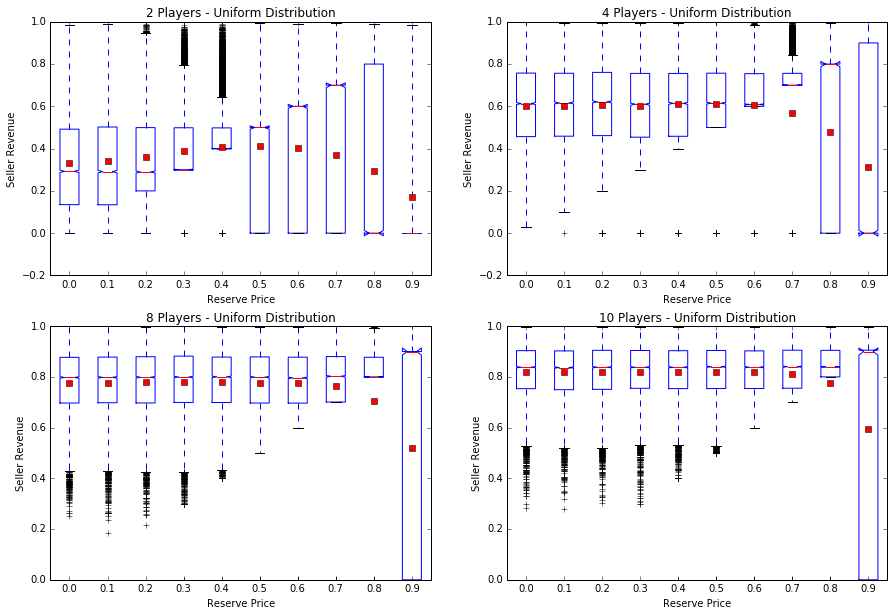

In [67]:
from decimal import *
import matplotlib.pyplot as plt
import math
%matplotlib inline

players = [2,4,8,10]
steps = 10
trials = 10000
items = 1

ax = plt.figure(figsize=(15,10))
trend_data = np.zeros((len(players),2,steps))

for i in range(0,len(players)):
    
    plt.subplot(2,2,i+1)
    rev, thresh = get_revenue(players[i],items,steps,trials,second_price=True)
    #print(str(players[i])," Players\nMedian: ",[float(Decimal("%.2f" % e)) for e in np.median(rev,axis=1)],
    #      "\nMean  : ",[float(Decimal("%.2f" % e)) for e in np.mean(rev,axis=1)] )
    l1 = plt.boxplot(np.transpose(rev),notch=True,showmeans=True)

    n = players[i]
    n_fact = math.factorial(players[i])
    theo_rev_0 = (n-1)/(n+1)

    theo_thresh = 1/(1+1/(n-1/math.factorial(n-2)))

    k = (theo_thresh+0.1)*steps


    theo_rev = theo_rev_0 + \
                (n_fact - n + 1)*np.power(theo_thresh,n) + \
                (n*theo_rev_0 - n_fact)*np.power(theo_thresh,n+1)

    #l2, = plt.plot(k,theo_rev, 'og')
    plt.xticks([i for i in range(1,steps+1)],thresh)
    plt.xlabel('Reserve Price')
    plt.ylabel('Seller Revenue')
    plt.title(str(players[i])+' Players - Uniform Distribution')
    trend_data[i,0,:] = np.mean(rev,axis=1)
    trend_data[i,1,:] = np.median(rev,axis=1)
    
plt.show()

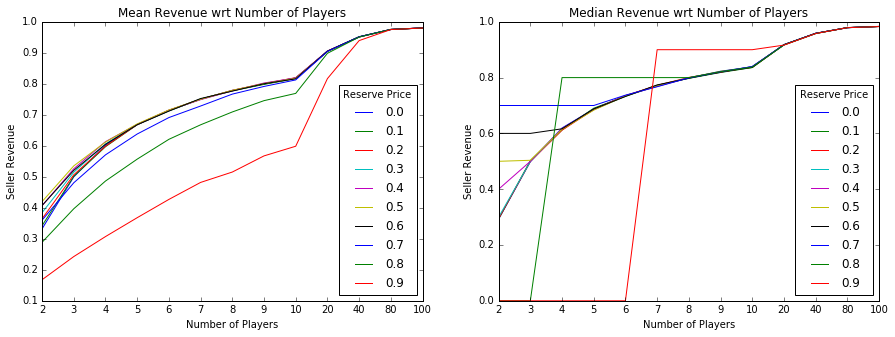

In [53]:
ax = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(trend_data[:,0,:])
plt.xticks([i for i in range(0,len(players))],players)
plt.xlabel('Number of Players')
plt.ylabel('Seller Revenue')
plt.title('Mean Revenue wrt Number of Players')
plt.legend(thresh,loc='lower right',title='Reserve Price')
plt.subplot(1,2,2)
plt.plot(trend_data[:,1,:])
plt.xticks([i for i in range(0,len(players))],players)
#plt.yticks([i for i in range(0,len(thresh))],thresh)
plt.xlabel('Number of Players')
plt.ylabel('Seller Revenue')
plt.title('Median Revenue wrt Number of Players')
plt.legend(thresh,loc='lower right',title='Reserve Price')

### Single Item, First Price Auction

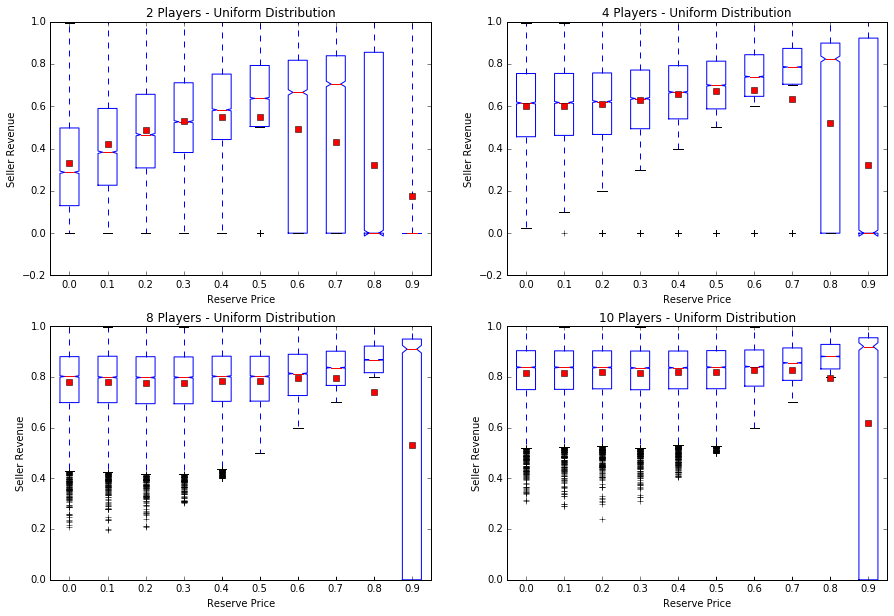

In [68]:
from decimal import *
import matplotlib.pyplot as plt
import math
%matplotlib inline

players = [2,4,8,10]
#players = [2,3,4,5,6,7,8,9,10,20,40,80,100]
steps = 10
trials = 10000
items = 1

ax = plt.figure(figsize=(15,10))
trend_data = np.zeros((len(players),2,steps))

for i in range(0,len(players)):
    
    plt.subplot(2,2,i+1)
    rev, thresh = get_revenue(players[i],items,steps,trials,second_price=False)
    #print(str(players[i])," Players\nMedian: ",[float(Decimal("%.3f" % e)) for e in np.median(rev,axis=1)],
    #      "\nMean  : ",[float(Decimal("%.3f" % e)) for e in np.mean(rev,axis=1)] )
    l1 = plt.boxplot(np.transpose(rev),notch=True,showmeans=True)

    n = players[i]
    n_fact = math.factorial(players[i])
    theo_rev_0 = (n-1)/(n+1)

    theo_thresh = 1/(1+1/(n-1/math.factorial(n-2)))

    k = (theo_thresh+0.1)*steps


    theo_rev = theo_rev_0 + \
                (n_fact - n + 1)*np.power(theo_thresh,n) + \
                (n*theo_rev_0 - n_fact)*np.power(theo_thresh,n+1)

    #l2, = plt.plot(k,theo_rev, 'og')
    plt.xticks([i for i in range(1,steps+1)],thresh)
    plt.xlabel('Reserve Price')
    plt.ylabel('Seller Revenue')
    plt.title(str(players[i])+' Players - Uniform Distribution')
    trend_data[i,0,:] = np.mean(rev,axis=1)
    trend_data[i,1,:] = np.median(rev,axis=1)

#plt.plot(thresh,np.mean(rev,axis=1))
plt.show()

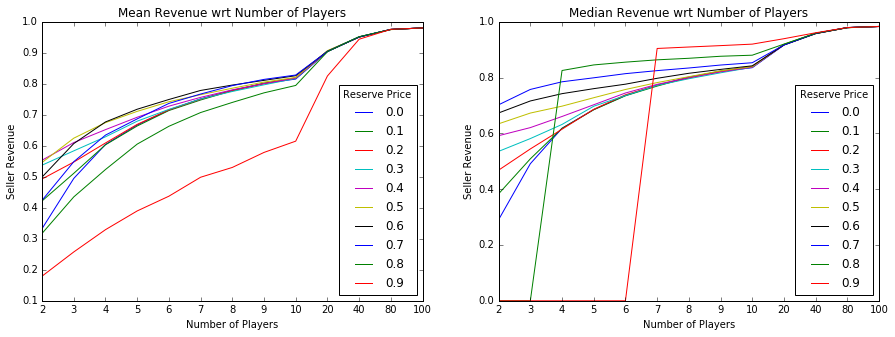

In [65]:
ax = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(trend_data[:,0,:])
plt.xticks([i for i in range(0,len(players))],players)
plt.xlabel('Number of Players')
plt.ylabel('Seller Revenue')
plt.title('Mean Revenue wrt Number of Players')
plt.legend(thresh,loc='lower right',title='Reserve Price')
plt.subplot(1,2,2)
plt.plot(trend_data[:,1,:])
plt.xticks([i for i in range(0,len(players))],players)
#plt.yticks([i for i in range(0,len(thresh))],thresh)
plt.xlabel('Number of Players')
plt.ylabel('Seller Revenue')
plt.title('Median Revenue wrt Number of Players')
plt.legend(thresh,loc='lower right',title='Reserve Price')